# Imports

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk import word_tokenize
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords

import pyarabic.araby as araby


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Data preperation

In [24]:
df = pd.read_json('/kaggle/input/arb-egy-cmp-corpus/ar_arz_wiki_corpus.json',lines=True)

In [25]:
len(df)

18863

In [26]:
#for this task i will take 10% of the data to be able to run it and not overload the ram4
# keep only 10% of the data
df = df.sample(frac=0.1)
len(df)

1886

In [27]:
def cleanArabicText(sentence):
#     st = ISRIStemmer() #returns Arabic root for the given token
    words = word_tokenize(sentence) 
    stopwords_list = stopwords.words('arabic')
    words = [araby.strip_diacritics(w) for w in words if araby.strip_diacritics(w) not in stopwords_list]
    return ' '.join(words)


In [28]:
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df

,text,filename,label
0,دهب فيلم\nدهب فيلم استعراضى مصري انتاج عام بطو...,doc_001294.txt,ar
1,محمود الخطيب\nمحمود الخطيب كان لعيب كوره مصرى ...,doc_003459.txt,arz
2,مصطفى حجازى\nمصطفى حجازى سياسى مصرى إختاره رئي...,doc_000016.txt,arz
3,نادى الرائد السعوديه\nنادى الرائد السعودى ده ن...,doc_008526.txt,arz
4,الكتله الاسلاميه\nالكتلة الاسلامية هيا تحالف ا...,doc_000856.txt,arz
...,...,...,...
1881,تنمية مستدامة\nالتنمية المستدامة هي عملية تطوي...,doc_007187.txt,ar
1882,اكس بوكس\nاكس بوكس ده عباره عن جهاز العاب ترفي...,doc_001811.txt,arz
1883,الإتحاد الوطني الأوكراني\nالأوكرانية الإتحاد ا...,doc_010153.txt,ar
1884,ابن أبي البيان\nسديد الدين أبو الفضل داود بن أ...,doc_008236.txt,ar


In [31]:
df.text[9]

'اليوم العالمي للسكري\nاليوم العالمي للسكري هو يوم عالمي للتوعية من مخاطر داء السكري ويحتفى به في نوفمبر من كل عام\nوفيما تدوم الحملة على السكري طوال العام فان تحديد ذلك التاريخ تم من قبل الاتحاد الدولي للسكري ومنظمة الصحة العالمية إحياء لذكرى عيد ميلاد فردريك بانتنغ الذي شارك تشارلز بيست في اكتشاف مادة الأنسولين عام وهي المادة الضرورية لبقاء الكثيرين من مرضى السكري على قيد الحياة\nفي كل عام يتم التركيز في اليوم العالمي للسكري على مواضيع لها صلة بمرض السكري وحقوق الإنسان السكري وأسلوب الحياة العصرية السكري والسمنة السكري في الضعفاء وسيئي التغذية السكري في الأطفال والمراهقين\nوبالنسبة لحملة فستركز الحملة حول موضوعات الوقاية والتعليم'

In [32]:
df['text_cleaned'] = df['text'].apply(cleanArabicText)

In [33]:
df.text_cleaned[9]

'اليوم العالمي للسكري اليوم العالمي للسكري يوم عالمي للتوعية مخاطر داء السكري ويحتفى عام وفيما تدوم الحملة السكري طوال العام فان تحديد التاريخ تم الاتحاد الدولي للسكري ومنظمة الصحة العالمية إحياء لذكرى عيد ميلاد فردريك بانتنغ شارك تشارلز بيست اكتشاف مادة الأنسولين عام وهي المادة الضرورية لبقاء الكثيرين مرضى السكري قيد الحياة عام يتم التركيز اليوم العالمي للسكري مواضيع صلة بمرض السكري وحقوق الإنسان السكري وأسلوب الحياة العصرية السكري والسمنة السكري الضعفاء وسيئي التغذية السكري الأطفال والمراهقين وبالنسبة لحملة فستركز الحملة حول موضوعات الوقاية والتعليم'

In [34]:
texts=df.text_cleaned.values

In [35]:
len(texts)

1886

In [36]:
tokenized_corpus = [word_tokenize(text) for text in texts]

In [37]:
len(tokenized_corpus)

1886

In [38]:
tokenized_corpus[4][:15]

['الكتله',
 'الاسلاميه',
 'الكتلة',
 'الاسلامية',
 'تحالف',
 'احزاب',
 'اسلام',
 'سياسى',
 'فى',
 'مصر',
 'إبتدا',
 'يوم',
 'اكتوبر',
 'سنة',
 'بتضم']

In [39]:
# convert words to enteries in a dictionary
corpus={}
inverse_corpus={}
counter=0
for text in tokenized_corpus:
    for word in text:
        if word not in corpus:
            corpus[word]=counter
            inverse_corpus[counter]=word
            counter+=1

In [40]:
len(corpus)

111871

In [19]:
corpus['مصر']

34

In [20]:
inverse_corpus[34]

'مصر'

In [21]:
len(corpus)

395942

# The Model
We’re going to train a simple neural network with a single hidden layer to perform a certain task, but then we’re not actually going to use that neural network for the task we trained it on.Instead, the goal is actually just to learn the weights of the hidden layer–we’ll see that these weights are actually the “word embedding” that we’re trying to learn.



![](http://mccormickml.com/assets/word2vec/training_data.png)

We’re going to train the neural network to do the following. Given a specific word in the middle of a sentence (the input word), look at the words nearby and pick one at random. The network is going to tell us the probability for every word in our vocabulary of being the “nearby word” that we chose.
The output probabilities are going to relate to how likely it is find each vocabulary word nearby our input word

# Skipgram

![](http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png)

In [41]:
class SkipGramDataset(Dataset):
    def __init__(self, corpus, window_size,vocab_dict):
        self.corpus = corpus
        self.vocab_dict=vocab_dict
        
        self.window_size = window_size
        self.samples = []
        
        self.samplesX=[]
        self.samplesY=[]

        for words in corpus:
            for i,word in enumerate(words):
                center_word = word
                context_words = []
                for j in range(i - window_size, i + window_size + 1):
                    if j != i and j >= 0 and j < len(words):
                        context_words.append(words[j])
                self.samples.append((center_word, context_words))
        
        for x in self.samples:
            input_word=x[0]
            for y in x[1]:
                if y != input_word:
                    self.samplesX.append(input_word)
                    self.samplesY.append(y)
        
        
    def test(self):
        return self.samplesX,self.samplesY
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        center_word, context_words = self.samplesX[idx],self.samplesY[idx]
        
        return torch.LongTensor([self.vocab_dict[center_word]]), torch.LongTensor([self.vocab_dict[context_words]])


In [42]:
class SkipGramNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, center_word):
        center_embed = self.embedding(center_word)
        output = self.linear(center_embed)
        return output


In [43]:
vocab_size=len(corpus)
embedding_dim=10
window_size=4
num_epochs=10
batch_size=128
lr=1e-3

In [44]:
from tqdm import tqdm
def train_skipgram(corpus,vocab_dict, vocab_size, embedding_dim, window_size, num_epochs, batch_size, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = SkipGramNN(vocab_size, embedding_dim).to(device)
    dataset = SkipGramDataset(corpus,window_size,vocab_dict)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for center_word, context_words in dataloader:
            center_word = center_word.to(device)
            
            context_words = context_words.to(device)
            output = model(center_word)

            loss = criterion(torch.squeeze(output), context_words.view(-1))
            running_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss/len(dataloader)))
    
    return model.embedding.weight.data.cpu().numpy()

In [45]:
weights=train_skipgram(tokenized_corpus,corpus,vocab_size,embedding_dim,window_size,num_epochs,batch_size,lr)

 10%|█         | 1/10 [00:28<04:18, 28.71s/it]

Epoch [1/10], Loss: 10.3121


 20%|██        | 2/10 [00:57<03:50, 28.79s/it]

Epoch [2/10], Loss: 9.3480


 30%|███       | 3/10 [01:26<03:21, 28.80s/it]

Epoch [3/10], Loss: 9.1410


 40%|████      | 4/10 [01:55<02:53, 28.84s/it]

Epoch [4/10], Loss: 9.0025


 50%|█████     | 5/10 [02:24<02:24, 28.83s/it]

Epoch [5/10], Loss: 8.8727


 60%|██████    | 6/10 [02:52<01:55, 28.80s/it]

Epoch [6/10], Loss: 8.7472


 70%|███████   | 7/10 [03:21<01:26, 28.81s/it]

Epoch [7/10], Loss: 8.6275


 80%|████████  | 8/10 [03:50<00:57, 28.79s/it]

Epoch [8/10], Loss: 8.5146


 90%|█████████ | 9/10 [04:19<00:28, 28.80s/it]

Epoch [9/10], Loss: 8.4097


100%|██████████| 10/10 [04:48<00:00, 28.81s/it]

Epoch [10/10], Loss: 8.3131


In [36]:
vocab_size

12927

In [46]:
weights.shape

(111871, 10)

In [39]:
weights[:,0]

array([ 1.9054399 ,  1.9854685 , -1.3738186 , ...,  1.0302651 ,
        1.1594689 , -0.49029243], dtype=float32)

In [42]:
plt.rcParams["font.family"] = "Arial"

In [50]:
!pip install --upgrade arabic-reshaper

In [58]:
inverse_corpus[1]

'بئر'

In [47]:
from sklearn.decomposition import PCA
# Create a PCA object
pca = PCA(n_components=2)

# Fit and transform the data
weights = pca.fit_transform(weights)



In [48]:
weights.shape

(111871, 2)

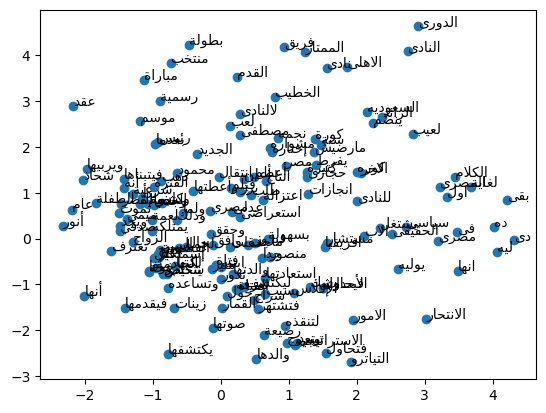

In [52]:
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# scatter plot
fig, ax = plt.subplots()
ax.scatter(weights[:150,0], weights[:150,1])
# add names above the points
for i in range(150):
    txt=arabic_reshaper.reshape(inverse_corpus[i])
    txt=get_display(txt)

    ax.annotate(txt, (weights[i,0], weights[i,1]+0.01))

# show the plot
plt.show()
